In [1]:
# Load all dictionaries
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import scikit_posthocs as sp
from scipy.stats import wilcoxon
from heatmaps_functions import *
from linares_plot import *

sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")

In [3]:
## 10 kfolds
paths_target=['C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_target_close_delay_kfold.xlsx']
paths_target_shuff=['C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_target_close_delay_kfold.xlsx']

In [ ]:
## 20 kfolds
paths_target=['C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\IEM_target_close_delay_kfold.xlsx']
paths_target_shuff=['C:\\Users\\David\\Desktop\\KI_Desktop\\data_reconstructions\\IEM\\shuff_IEM_target_close_delay_kfold.xlsx']

In [4]:
df_target=[]
df_target_shuff=[]

for PathI in paths_target:
    path_save_signal =PathI
    #
    dec_thing = path_save_signal.split('\\')[-1].split('.')[0].split('_')[1]
    distance = path_save_signal.split('\\')[-1].split('.')[0].split('_')[2]
    training_region = path_save_signal.split('\\')[-1].split('.')[0].split('_')[3]
    #
    df_x = pd.read_excel(PathI)
    df_x['item'] = dec_thing
    df_x['trained'] =training_region
    df_x['distance'] = distance
    #
    df_target.append(df_x)
    
#
df_target=pd.concat(df_target, axis=0)

####################

for PathI in paths_target_shuff:
    path_save_signal =PathI
    #
    dec_thing = path_save_signal.split('\\')[-1].split('.')[0].split('_')[2]
    distance = path_save_signal.split('\\')[-1].split('.')[0].split('_')[3]
    training_region = path_save_signal.split('\\')[-1].split('.')[0].split('_')[4]
    #
    df_x = pd.read_excel(PathI)
    df_x['item'] = dec_thing
    df_x['trained'] =training_region
    df_x['distance'] = distance
    #
    df_target_shuff.append(df_x)
    
#
df_target_shuff=pd.concat(df_target_shuff, axis=0)

In [8]:
df=df_target
df_shuff = df_target_shuff
df['label']= df['item'] + ' ' + df['distance'] 
df['label'] = df['label'].replace(['target close', 'target far', 'dist close', 'dist far'], ['tc', 'tf', 'dc', 'df'])

In [9]:
df_time=[]

for cond in [ '1_7']:
    for reg in ['visual']:
        for subj in ['d001']:
            for dist in ['close']: ##falta el close
                for trained in ['delay']:
                    for item in ['target']:
                        for t in df.times.unique(): 
                            dec_sig = df.loc[(df['region']==reg) & (df['times']== t) & 
                                   ( df['condition']==cond) & (df['subject']==subj) &  
                                   ( df['distance']==dist) & (df['trained']==trained) & 
                                   ( df['item']==item)]
                            #
                            dec_shuff = df_shuff.loc[(df_shuff['region']==reg) & (df_shuff['times']== t) & 
                                   ( df_shuff['condition']==cond) & (df_shuff['subject']==subj) &  
                                   ( df_shuff['distance']==dist) & (df_shuff['trained']==trained) & 
                                   ( df_shuff['item']==item)].decoding.mean()
                            #
                            decoding_ = dec_sig.decoding.iloc[0]  - dec_shuff
                            df_time.append( [t, decoding_, reg, subj, cond, dec_sig.label.iloc[0], item, trained, dist] )   
                            ####)
#
df_time = pd.DataFrame(df_time)
df_time.columns=['times', 'decoding', 'region', 'subject', 'condition', 'label', 'item', 'trained', 'distance']


In [11]:
presentation_period= 0.35 #stim presnetation time
presentation_period_cue=  0.50 #presentation of attentional cue time
pre_stim_period= 0.5 #time between cue and stim
resp_time = 4  #time the response is active


def tiemcourse_4_conditions(df_plot, title_plot):
    ##
    ###
    ####   In the input dataframe you need the following columns:
    ###  'new_mean', 'inf', 'sup', 'brain_reg', 'time', 'condition'
    ## 
    pal = ['darkblue',  'darkorange',  'darkgreen'] #sns.color_palette("tab10", n_colors=12, desat=1).as_hex()[0:3]
    ##
    fig = plt.figure(figsize=(12,10))
    for indx_c, condition in enumerate(['1_0.2', '1_7', '2_0.2', '2_7']): 
        #features of the plot for the different conditions. Fixed values
        if condition == '1_0.2':
            delay1 = 0.2
            delay2 = 11.8
            cue=0
            t_p = cue + presentation_period_cue + pre_stim_period 
            d_p = t_p + presentation_period +delay1 
            r_t = d_p + presentation_period + delay2
            xlim = [1, 30]

        elif condition == '1_7':
            delay1 = 7
            delay2 = 5
            cue=0
            t_p = cue + presentation_period_cue + pre_stim_period 
            d_p = t_p + presentation_period +delay1 
            r_t = d_p + presentation_period + delay2
            xlim = [1, 30]

        elif condition == '2_0.2':
            delay1 = 0.2
            delay2 = 12
            cue=0
            d_p = cue + presentation_period_cue + pre_stim_period 
            t_p = d_p + presentation_period +delay1 
            r_t = t_p + presentation_period + delay2   
            xlim = [1, 30]

        elif condition == '2_7':
            delay1 = 7
            delay2 = 12
            cue=0
            d_p = cue + presentation_period_cue + pre_stim_period 
            t_p = d_p + presentation_period +delay1 
            r_t = t_p + presentation_period + delay2
            xlim = [1, 36]


        start_hrf = 4 #start of the Hemodynamic response (4seconds)
        sec_hdrf = 3 #time it can last

        d_p1 = (start_hrf + d_p) ##strat of didtractor (time)
        t_p1 = (start_hrf +t_p) ## strat of target (time)
        r_t1=  (start_hrf + r_t) ## start of response (time)
        #
        d_p2 = d_p1 + sec_hdrf # end of distractor (time)
        t_p2 = t_p1 + sec_hdrf # end of target (time)
        r_t2=  r_t1 + sec_hdrf + resp_time #end of response (time)

        y_vl_min = -10 #df_all_by_subj.Decoding.min() #values min and max
        y_vl_max = 10 #◙df_all_by_subj.Decoding.max()

        #fig = plt.figure()
        ax = fig.add_subplot(2,2, indx_c+1) 
        
        data_cond = df_plot.loc[df_plot['condition']==condition ]
        sns.lineplot( ax=ax, x="times", y="decoding", hue='region', ci=68,
                     hue_order =  ['visual', 'ips', 'pfc'], palette=pal, data=data_cond)
        plt.plot([0, 35], [0,0], 'k--')   ## plot chance level (0)
        plt.fill_between(  [ t_p1, t_p2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='b', alpha=0.3) #, label='target'  ) #plot aprox time of target
        plt.fill_between(  [ d_p1, d_p2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='g', alpha=0.3) #, label='distractor'  ) #plot aprox time of distractor
        plt.fill_between(  [ r_t1, r_t2 ], [y_vl_min, y_vl_min], [y_vl_max, y_vl_max], color='y', alpha=0.3) #, label='response'  )   #plot aprox time of response
        #
        TITLE_BR = condition 
        plt.title(TITLE_BR) #condition title
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.xticks([5,15,25]) #just this tcks
        plt.ylim(-20, 20)
        plt.yticks([-20, -10, 0 , 10, 20])
        plt.xlim(xlim)
        plt.ylabel('decoding')
        if indx_c==3: #legend in just this condition (to avoid repetitions)       
            plt.gca().legend(frameon=False, bbox_to_anchor=(1.1, 1.05), fontsize=15)
            plt.xticks([10, 20 ,30])

        else:
            plt.gca().legend(loc= 1, frameon=False).remove()



    ##
    plt.suptitle( title_plot, fontsize=18) ## main title
    plt.tight_layout(w_pad=1, h_pad=1, rect=[0, 0.03, 1, 0.95]) #correct the space between graphs
    plt.show(block=False) #show
    

    

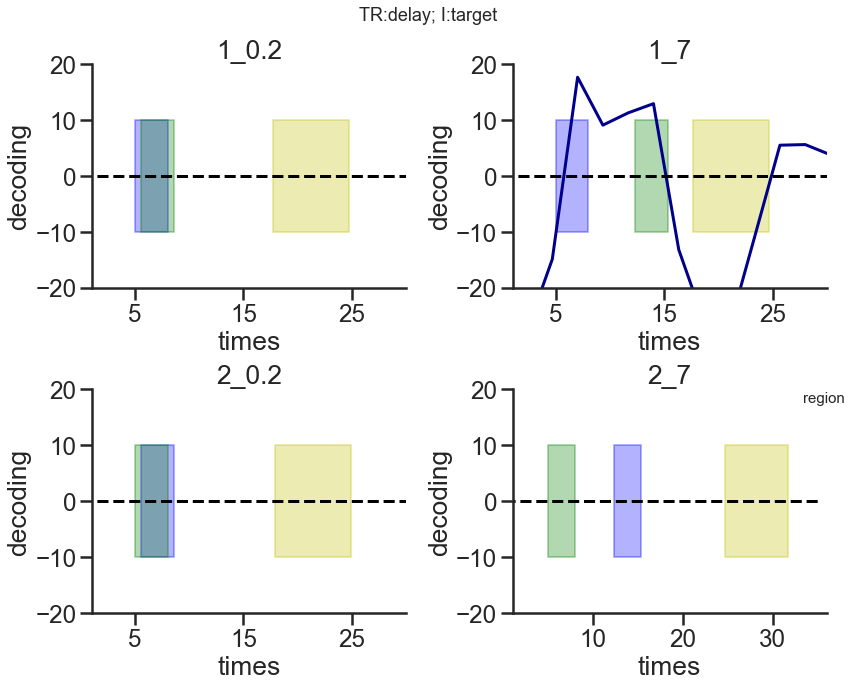

In [12]:
df_x = df_time.loc[(df_time['trained']=='delay') & (df_time['item']=='target') ]
tiemcourse_4_conditions(df_x , 'TR:delay; I:target')